# Neural Population
# Mehrab Kalantary - 99222088

# Implement Neuron Class Using LIF Model
 * update function: updates neuron potential at time j
 * (uses for external input)
 * update_u function: updates neuron potential by spiking another neuron at time j
 * (uses for internal input)
 * reset function: resets neuron potential from a specific time till end

In [7]:
import numpy as np
import random 
import matplotlib.patches as mpatches
from matplotlib.pyplot import *
import tqdm


class Neuron:
    """
    implement neuron class with LIF model which has two types, "exc" for excitatory and "inh" for inhibitory
    """
    def __init__(self, type="exc", index=0, population=0):
        self.population = population
        self.index = index
        self.type = type
        self.time = 100
        self.dt = 0.25
        self.u_rest = 0
        self.r = 10
        self.c = 5
        self.threshold = 2 + random.random() * 2
        self.timer = np.arange(0, self.time + self.dt, self.dt)
        self.tm = self.r * self.c
        self.i_input = 0
        self.u = [self.u_rest] * len(self.timer)
        
    def update(self, j, input):
        self.u[j] += self.u[j - 1] + (self.r * input - (self.u[j - 1] - self.u_rest)) / self.tm * self.dt
        result = 0
        if self.u[j] >= self.threshold:
            result = self.threshold - self.u_rest
            self.u[j] = self.u_rest
        return result

    def update_u(self, value, j, pre_type):
        if pre_type == "exc" or pre_type == "inh" and self.type == "inh":
            self.u[j] += value
        else:
            self.u[j] -= value
                
    def reset(self, from_time):
        for i in range(from_time, len(self.timer)):
            self.u[i] = self.u_rest
                
                
class RandomInput:
    def __init__(self, i=1, step=100):
        self.last_i = 0
        self.going_up = True
        self.i = i
        self.step = step

    def get(self, iterate):
        if iterate % 20 == 0:
            self.going_up = not self.going_up
        temp = random.random()
        if self.going_up:
            temp = self.last_i + temp * (self.i / 2)
        else:
            temp = self.last_i - temp * (self.i / 2)
        if temp > self.i * 2 or temp < 0:
            temp = random.random() * self.i
        self.last_i = temp
        return temp

# Population With Two Neurons
 * 1) excitatory <=> excitatory
 * 2) excitatory <=> inhibitory
 * 3) inhibitory <=> inhibitory

In [22]:
def connect(neuron1, neuron2, i_gen1=RandomInput(), i_gen2=RandomInput(), w=0.1, plot_title=None):
    input_neuron1 = [0] * len(neuron1.timer)
    input_neuron2 = [0] * len(neuron2.timer)
    
    # first neuron
    for i in range(len(neuron1.timer)):
        current_i = i_gen1.get(i)
        input_neuron1[i] = current_i
        result = neuron1.update(j=i, input=current_i)
        if result > 0:
            neuron2.update_u(w * result, j=i, pre_type=neuron1.type)
    
    # second neuson
    for i in range(len(neuron1.timer)):
        current_i = i_gen2.get(i)
        input_neuron2[i] = current_i
        result = neuron2.update(j=i, input=current_i)
        if result > 0:
            neuron1.update_u(w * result, j=i, pre_type=neuron2.type)
            neuron1.reset(i + 1)
            for update_time in range(i + 1, len(neuron1.timer)):
                neuron1.update(j=update_time, input=input_neuron1[update_time])
                
    # plotting
    fig = figure(num=None, figsize=(20, 10))
    fig.suptitle(plot_title, fontsize=22, fontweight='bold')
    subplot(221)
    plot(neuron1.timer, neuron1.u)
    ylabel('U')
    xlabel('Time')
    title('Neuron 1: U - Time Plot')
    grid(True)

    subplot(223)
    plot(neuron2.timer, neuron2.u)
    ylabel('U')
    xlabel('Time')
    title('Neuron 2: U - Time Plot')
    grid(True)

    subplot(222)
    plot(neuron1.timer, input_neuron1)
    ylabel('I')
    xlabel('Time')
    title('Neuron 1: I - Time Plot')
    grid(True)

    subplot(224)
    plot(neuron2.timer, input_neuron2)
    ylabel('I')
    xlabel('Time')
    title('Neuron 2: I - Time Plot')
    grid(True)

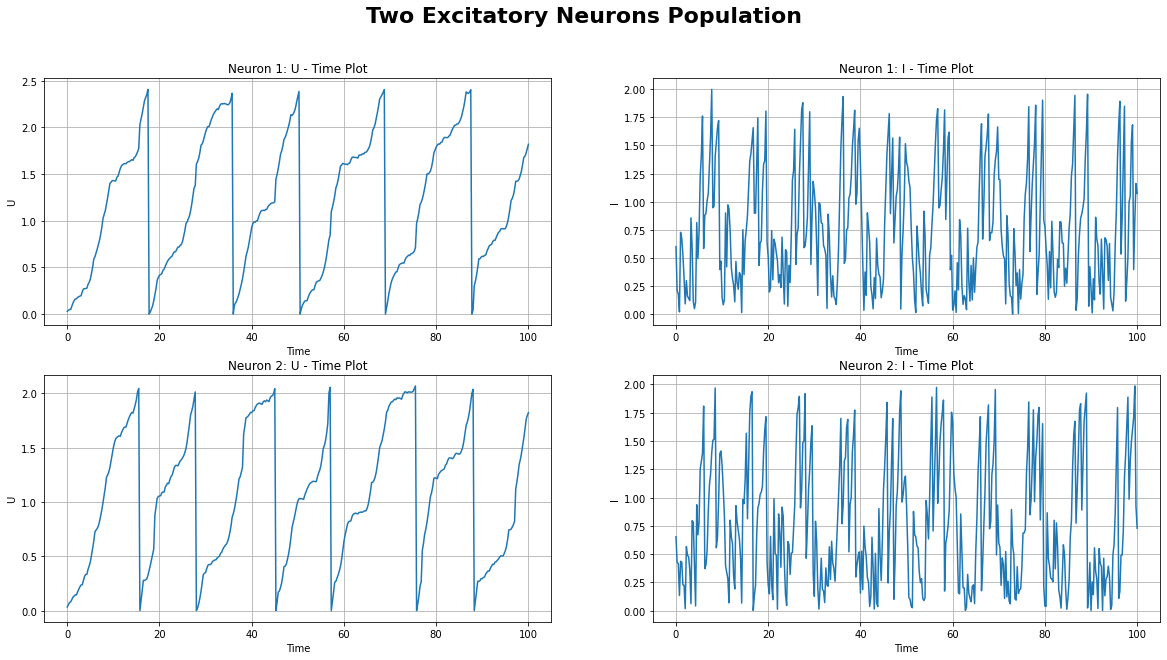

In [23]:
neuron1 = Neuron(type="exc", index=0)
neuron2 = Neuron(type="exc", index=1)
connect(neuron1, neuron2, plot_title="Two Excitatory Neurons Population")

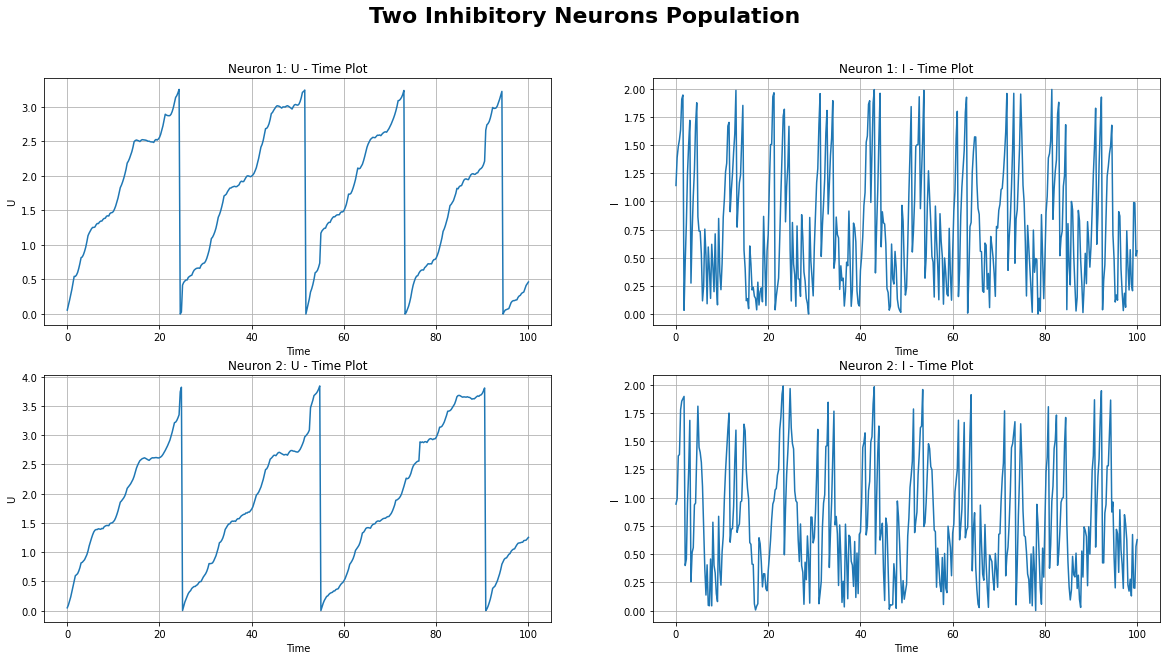

In [24]:
neuron1 = Neuron(type="inh", index=0)
neuron2 = Neuron(type="inh", index=1)
connect(neuron1, neuron2, plot_title="Two Inhibitory Neurons Population")

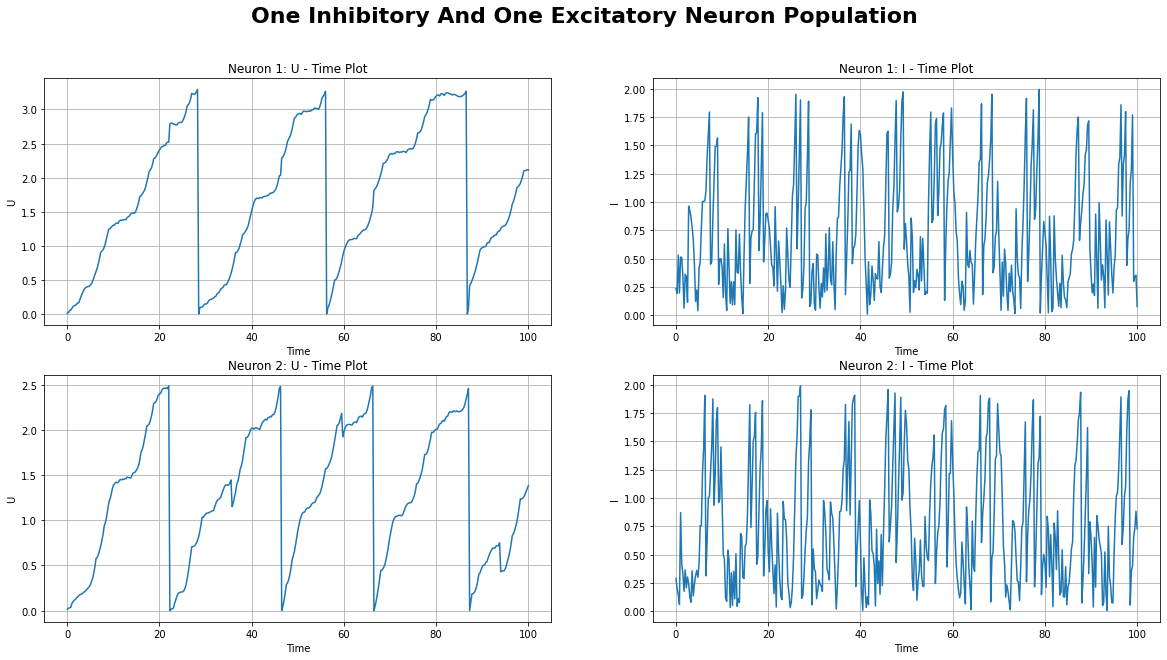

In [25]:
neuron1 = Neuron(type="inh", index=0)
neuron2 = Neuron(type="exc", index=1)
connect(neuron1, neuron2, plot_title="One Inhibitory And One Excitatory Neuron Population")

# Populations

In [26]:
class Population:
    def __init__(self, j_0=0.1, excitatory_N=800, inhibitory_N=200):
        self.excitatory_N = excitatory_N
        self.inhibitory_N = inhibitory_N
        self.N = inhibitory_N + excitatory_N
        self.w = j_0 / self.N
        self.population = []
        
    def activity(self, circle_size=2):
        c = 0
        for i in range(self.inhibitory_N):
            self.population.append(Neuron(type="inh", index=c))
            c += 1
        for i in range(self.excitatory_N):
            self.population.append(Neuron(type="exc", index=c))
            c += 1

        # spikes matrix 
        # rows show each neuron
        # columns show that neuron spiks or not (-1 for not and neuron index for yes)
        y = [[-1 for x in range(self.N)] for y in range(len(self.population[0].timer))]

        # yi : input in all timer
        i_gen = RandomInput()
        yi = [i_gen.get(i) for i in range(len(self.population[0].timer))]
        
        for i in (range(len(self.population[0].timer))):
            current_i = yi[i]
            for g in self.population:
                result = g.update(j=i, input=current_i)
                # check if neuron spikes or not
                if result > 0:
                    y[i][g.index] = g.index
                    # send internal input into population
                    for k in range(self.N):
                        self.population[k].update_u(self.w * result, j=i, pre_type=g.type)


        # plotting
        list1 = []
        for i in range(len(self.population[0].timer)):
            for g in range(self.N):
                if y[i][g] != -1:
                    list1.append((self.population[0].timer[i], y[i][g]))

        if len(list1) == 0:
            print("Not Single Neurons Fired!")
        else:
            cdict = {1: 'red', 2: 'blue'}
            color = []
            fig = figure(num=None, figsize=(20, 20))
            fig.suptitle('Population of ' +
                         str(self.excitatory_N) + " Excitatory Neurons and " +
                         str(self.inhibitory_N) + " Inhibitory Neurons", fontsize=22,
                         fontweight='bold')
            ax = subplot(211)
            list1 = list(zip(*list1))

            c = ["b" if y >= self.excitatory_N else "r" for y in list(list1[1])]

            scatter(list(list1[0]), list(list1[1]), c=c, s=circle_size)
            ylabel('Population Activity')
            xlabel('Time')
            title('Raster Plot')
            red_patch = mpatches.Patch(color='red', label='Excitatory Neuron')
            blue_patch = mpatches.Patch(color='blue', label='Inhibitory Neuron')
            legend(handles=[red_patch, blue_patch])
            ax.set_xlim(xmin=0, xmax=self.population[0].time)
            grid(True)

            ax = subplot(212)
            plot(self.population[0].timer, yi)
            ylabel('Input')
            xlabel('Time')
            title('Input - Time plot')
            ax.set_xlim(xmin=0, xmax=self.population[0].time)
            grid(True)

# Population Of 8 Excitatory Neurons and 2 Inhibitory Neurons

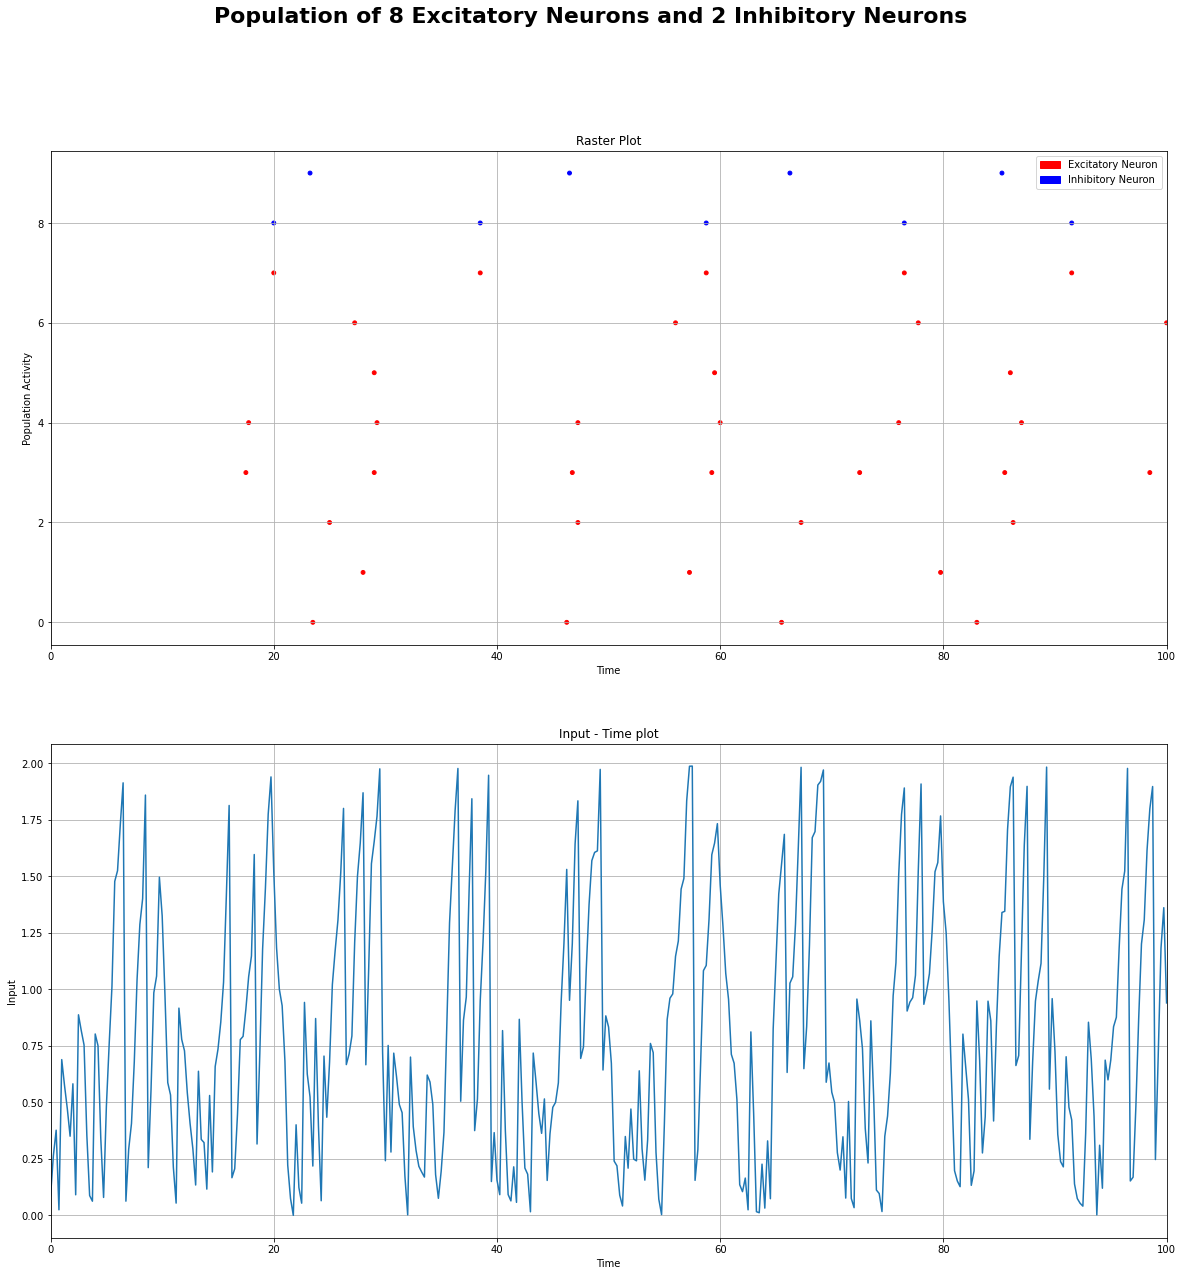

In [27]:
p = Population(excitatory_N=8, inhibitory_N=2)
p.activity(circle_size=15)

# Now We Draw Raster Plot For Big Populatoins

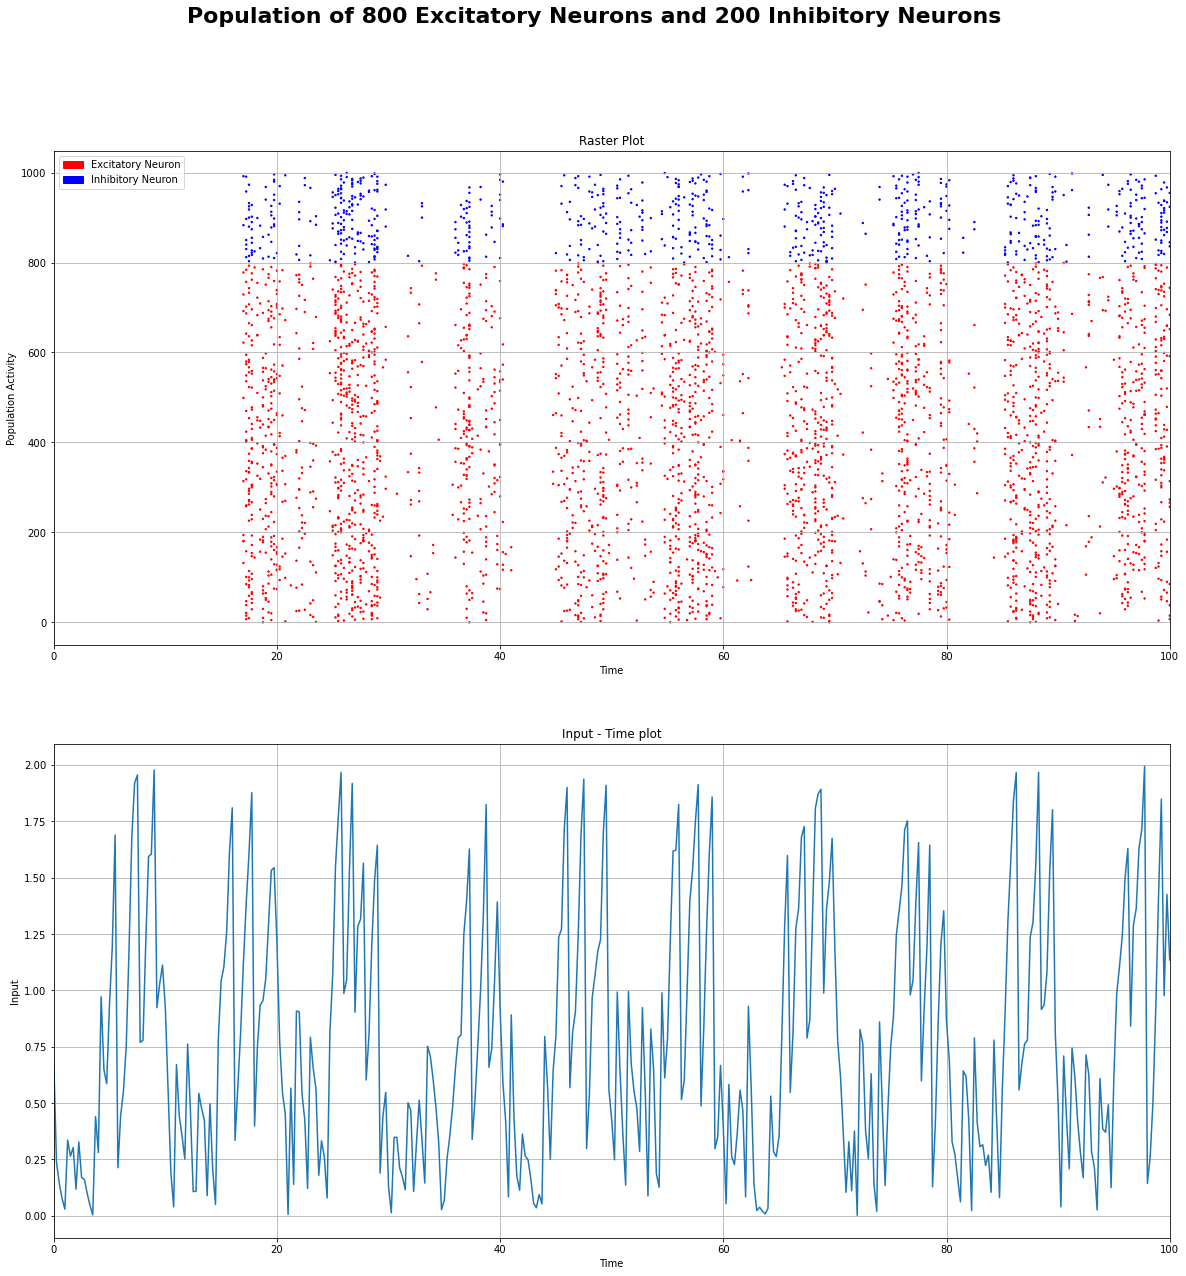

In [28]:
p = Population(excitatory_N=800, inhibitory_N=200)
p.activity()

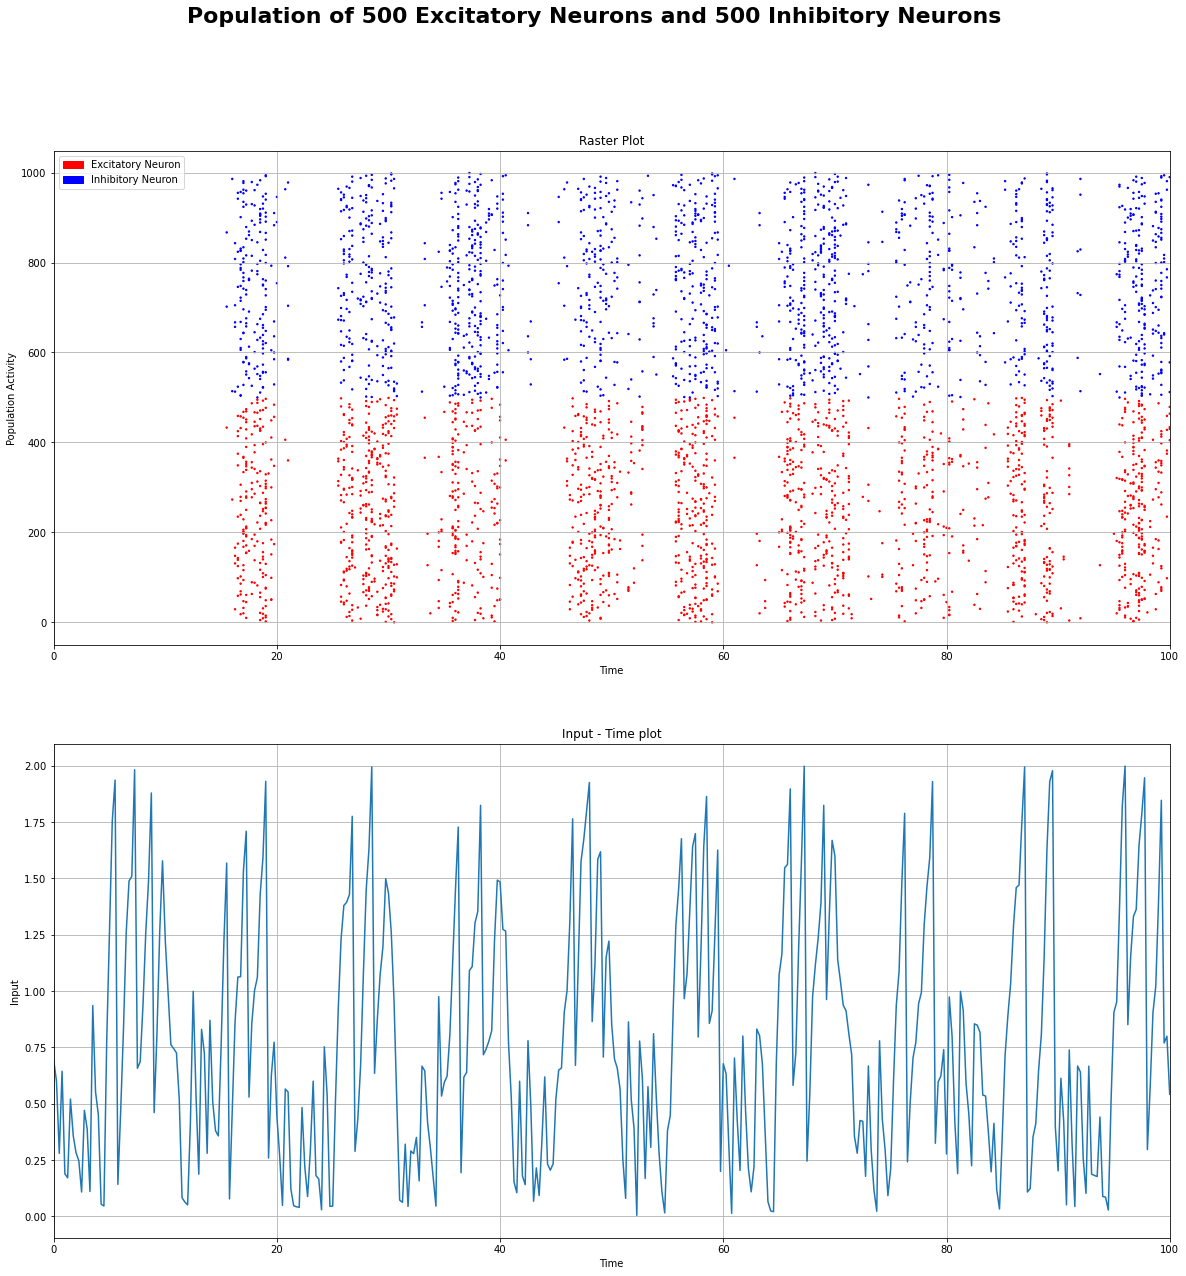

In [29]:
p = Population(excitatory_N=500, inhibitory_N=500)
p.activity()

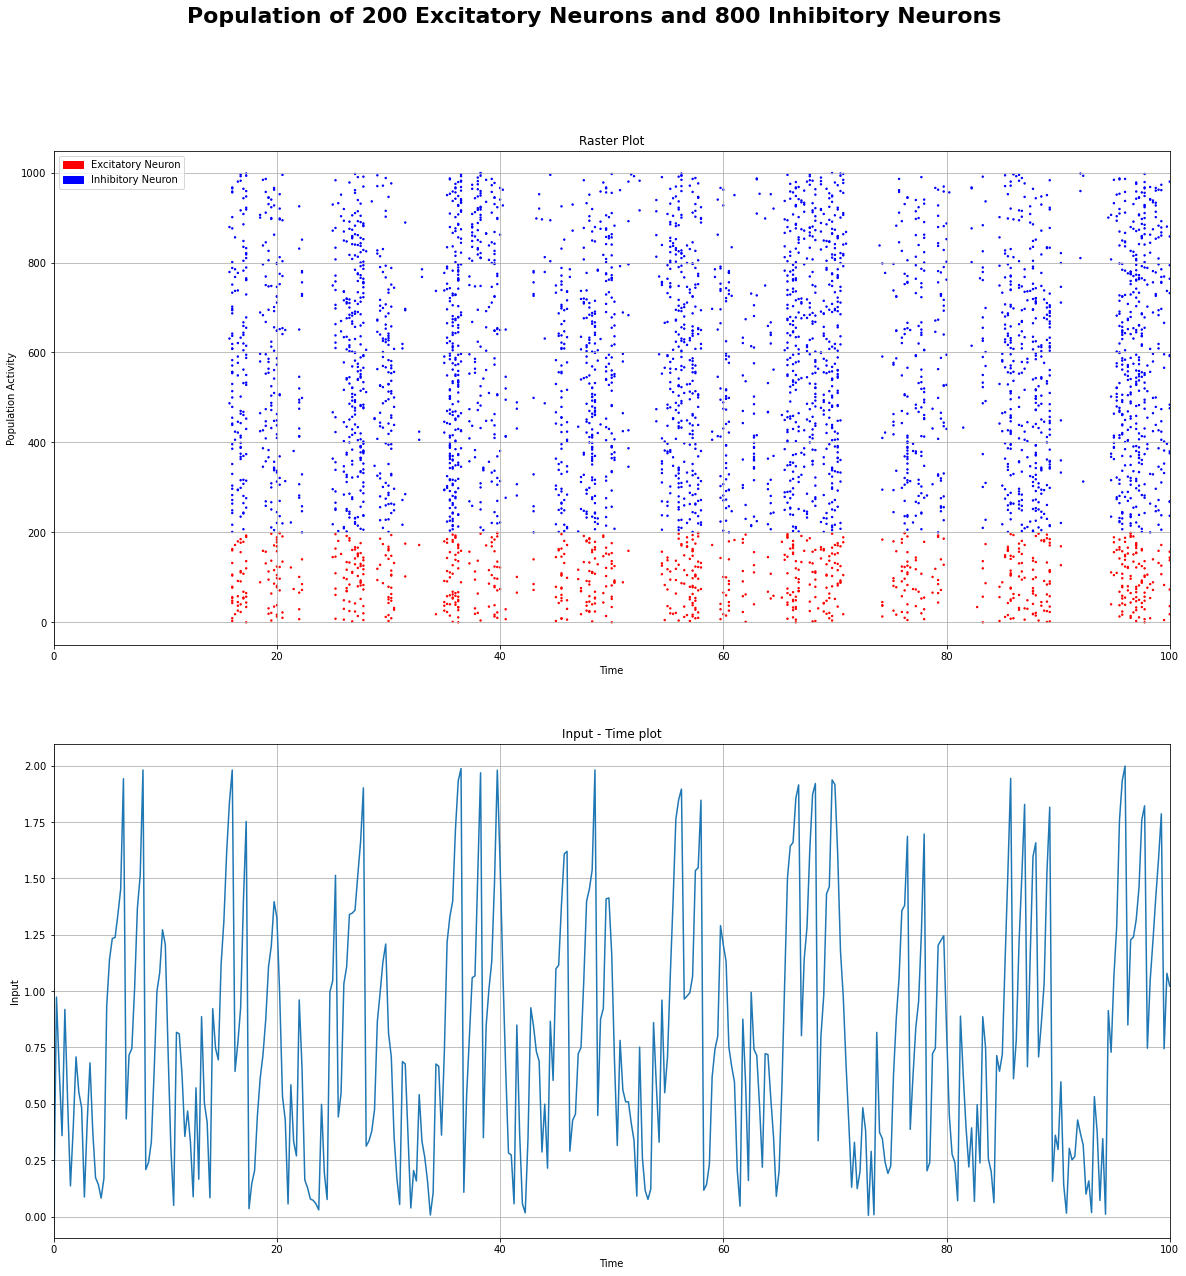

In [30]:
p = Population(excitatory_N=200, inhibitory_N=800)
p.activity()

# Three Populations

In [32]:
def three_populations(excitatory_N1, excitatory_N2, inhibitory_N, circle_size=1):
    N = excitatory_N1 + excitatory_N2 + inhibitory_N
    group = []
    w = []
    c = 0
    for i in range(inhibitory_N):
        group.append(Neuron(type="inh", index=c, population=1))
        c += 1
    for i in range(excitatory_N1):
        group.append(Neuron(type="exc", index=c, population=2))
        c += 1
    for i in range(excitatory_N2):
        group.append(Neuron(type="exc", index=c, population=3))
        c += 1

    w = [[0 for _ in range(N)] for _ in range(N)]

    for i in range(inhibitory_N):
        for j in range(inhibitory_N):
            w[i][j] = 1 / inhibitory_N
    for i in range(inhibitory_N, inhibitory_N + excitatory_N1):
        for j in range(inhibitory_N, inhibitory_N + excitatory_N1):
            w[i][j] = 1 / excitatory_N1
    for i in range(inhibitory_N + excitatory_N1, inhibitory_N + excitatory_N1 + excitatory_N2):
        for j in range(inhibitory_N + excitatory_N1, inhibitory_N + excitatory_N1 + excitatory_N2):
            w[i][j] = 1 / excitatory_N2


    w[excitatory_N1][0] = 0.04
    w[0][excitatory_N1] = 0.04
    w[excitatory_N1 + excitatory_N2][0] = 0.04
    w[0][excitatory_N1 + excitatory_N2] = 0.04


    y = [[-1 for x in range(N)] for y in range(len(group[0].timer))]
    yi = [0] * len(group[0].timer)
    Input_i = 1
    i_gen = RandomInput(i=Input_i, step=100)

    for i in (range(len(group[0].timer))):
        current_i = i_gen.get(i)
        yi[i] = current_i
        for g in group:
            if g.type == "inh":
                current_i = 0.4
            if g.population == 2:
                current_i *= 1.02
            result = g.update(j=i, input=current_i)
            if result > 0:
                y[i][g.index] = g.index
                for k in range(N):
                    if g.index != group[k].index:
                        group[k].update_u(w[g.index][k] * result, j=i, pre_type=g.type)

    # plotting
    list1 = []
    for i in range(len(group[0].timer)):
        for g in range(N):
            if y[i][g] != -1:
                list1.append((group[0].timer[i], y[i][g]))
    if len(list1) == 0:
        print("Not single Neurons Fired!")

    cdict = {1: 'red', 2: 'blue', 3: "green"}
    color = []
    fig = figure(num=None, figsize=(20, 20))
    fig.suptitle('Population of ' + str(excitatory_N1)+ " ," +str(excitatory_N2) + " Excitatory Neurons and " 
                 + str(inhibitory_N) + " Inhibitory Neurons", fontsize=22,
                 fontweight='bold')
    ax = subplot(211)
    list1 = list(zip(*list1))

    c = []
    for y in list(list1[1]):
        if y < inhibitory_N:
            c.append("g")
        if inhibitory_N <= y < excitatory_N1 + inhibitory_N:
            c.append("r")
        if y >= inhibitory_N + excitatory_N1:
            c.append("b")

    scatter(list(list1[0]), list(list1[1]), c=c, s=circle_size)
    ylabel('Activity')
    xlabel('Time')
    title('Raster Plot')
    red_patch = mpatches.Patch(color='red', label='Excitatory Neuron Group 1')
    green_patch = mpatches.Patch(color='green', label='Excitatory Neuron Group 2')
    blue_patch = mpatches.Patch(color='blue', label='Inhibitory Neuron')
    legend(handles=[red_patch, blue_patch, green_patch])
    ax.set_xlim(xmin=0, xmax=group[0].time)
    grid(True)

    ax = subplot(212)
    plot(group[0].timer, yi)
    ylabel('Input')
    xlabel('Time')
    title('Input - Time Plot')
    ax.set_xlim(xmin=0, xmax=group[0].time)
    grid(True)

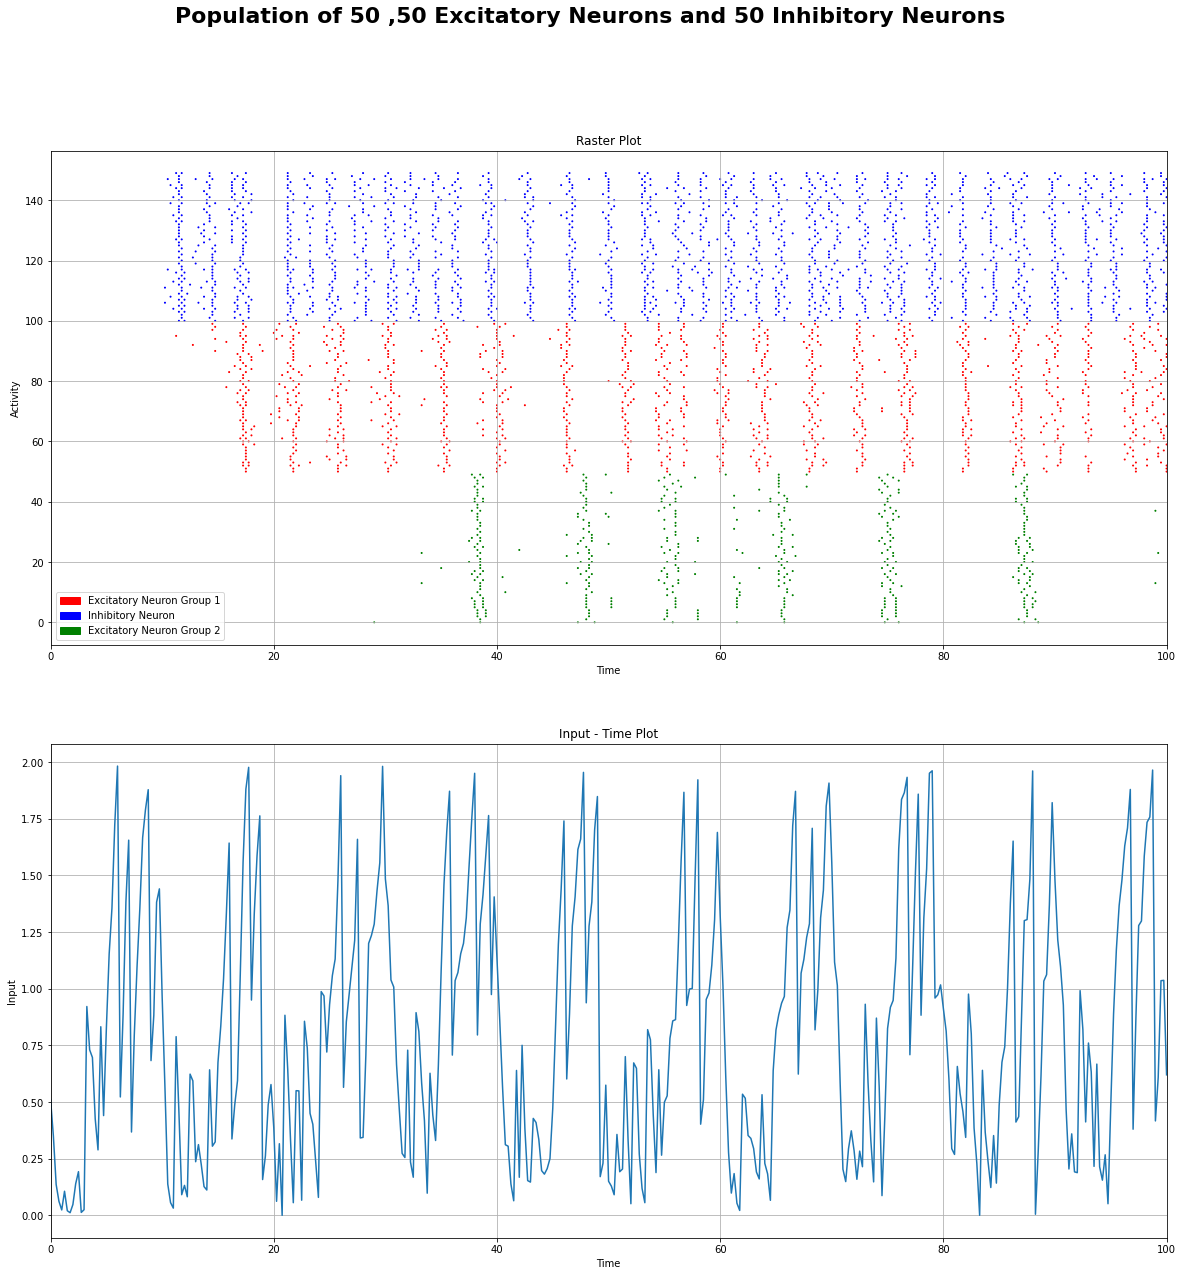

In [33]:
three_populations(50, 50, 50)

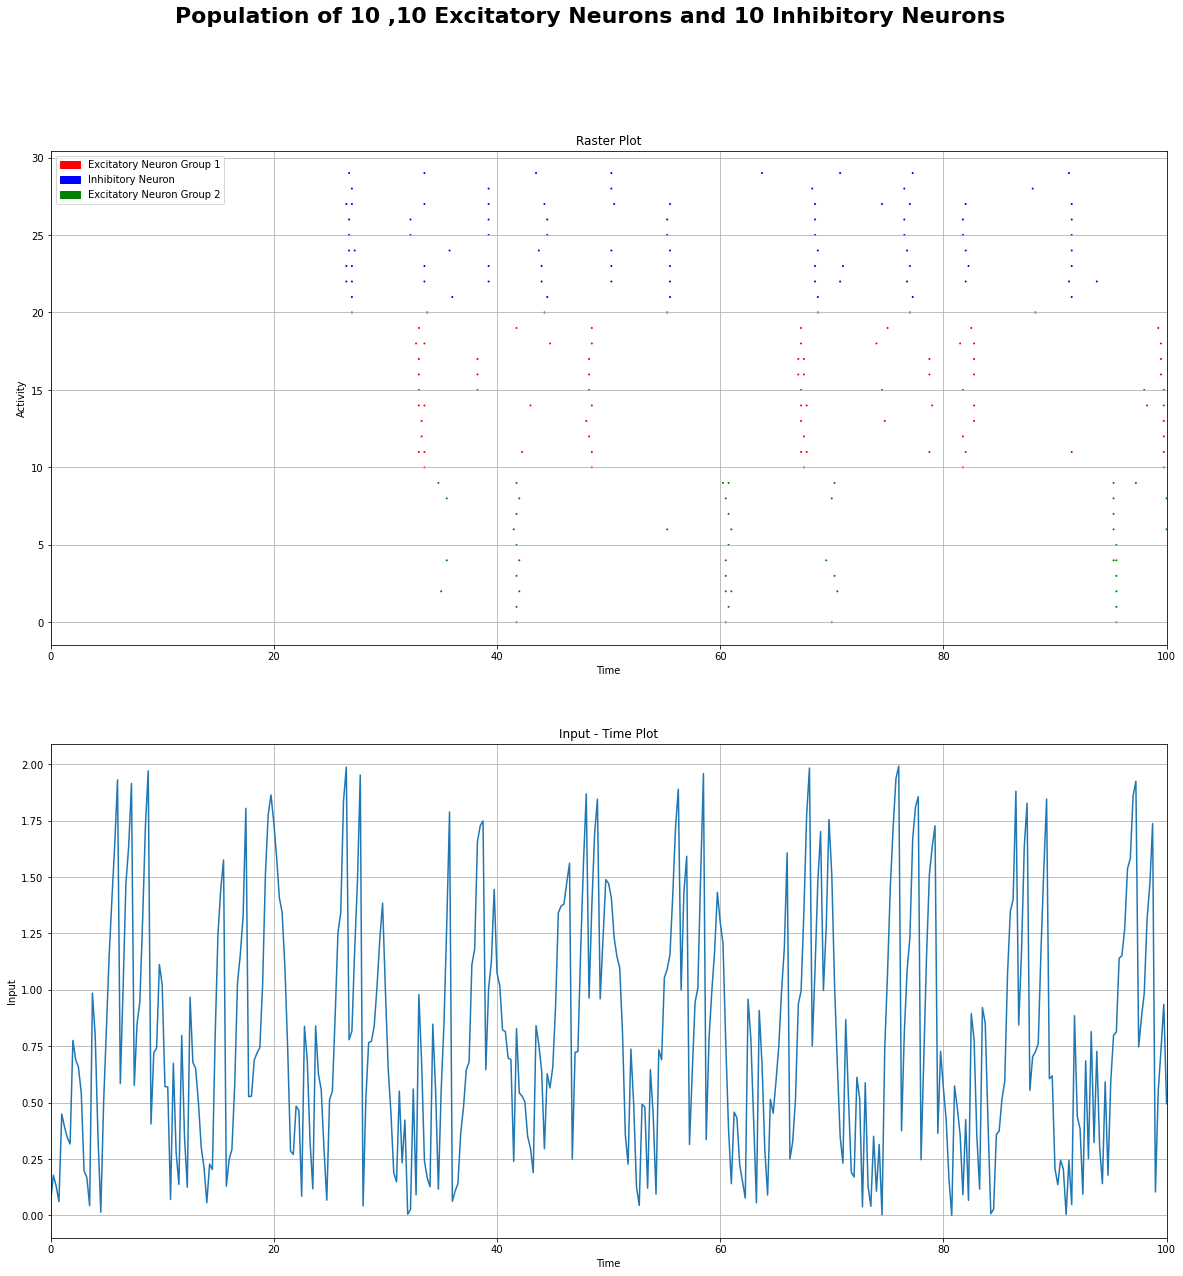

In [34]:
three_populations(10, 10, 10)